# ANKRD11

[KBG syndrome (KBGS)](https://omim.org/entry/148050) is caused by heterozygous mutation in the ANKRD11 gene. In this notebook, we have used
[pyphetools](https://github.com/monarch-initiative/pyphetools) to parse the clinical data included in the supplemental files of
[Martinez-Cayuelas E, et al. Clinical description, molecular delineation and genotype-phenotype correlation in 340 patients with KBG syndrome: addition of 67 new patients](https://pubmed.ncbi.nlm.nih.gov/36446582).

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}');
print(f"Using gpsea version {gpsea.__version__}");

Loaded HPO v2024-08-13
Using gpsea version 0.9.1.dev0


### ANKRD11
We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ANKRD11.

In [2]:
gene_symbol = 'ANKRD11'
mane_tx_id = 'NM_013275.6'
mane_protein_id = 'NP_037407.4' # ankyrin repeat domain-containing protein 11 [Homo sapiens]

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.21") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)

Loaded 337 phenopackets
Individuals Processed: 100%|██████████| 337/337 [03:30<00:00,  1.60individuals/s]


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Macrodontia,HP:0001572,211
Intellectual disability,HP:0001249,194
Abnormality of the hand,HP:0001155,189
Global developmental delay,HP:0001263,176
Delayed speech and language development,HP:0000750,160
Short stature,HP:0004322,150
Thick eyebrow,HP:0000574,126
Long philtrum,HP:0000343,121
Bulbous nose,HP:0000414,89
Triangular face,HP:0000325,83


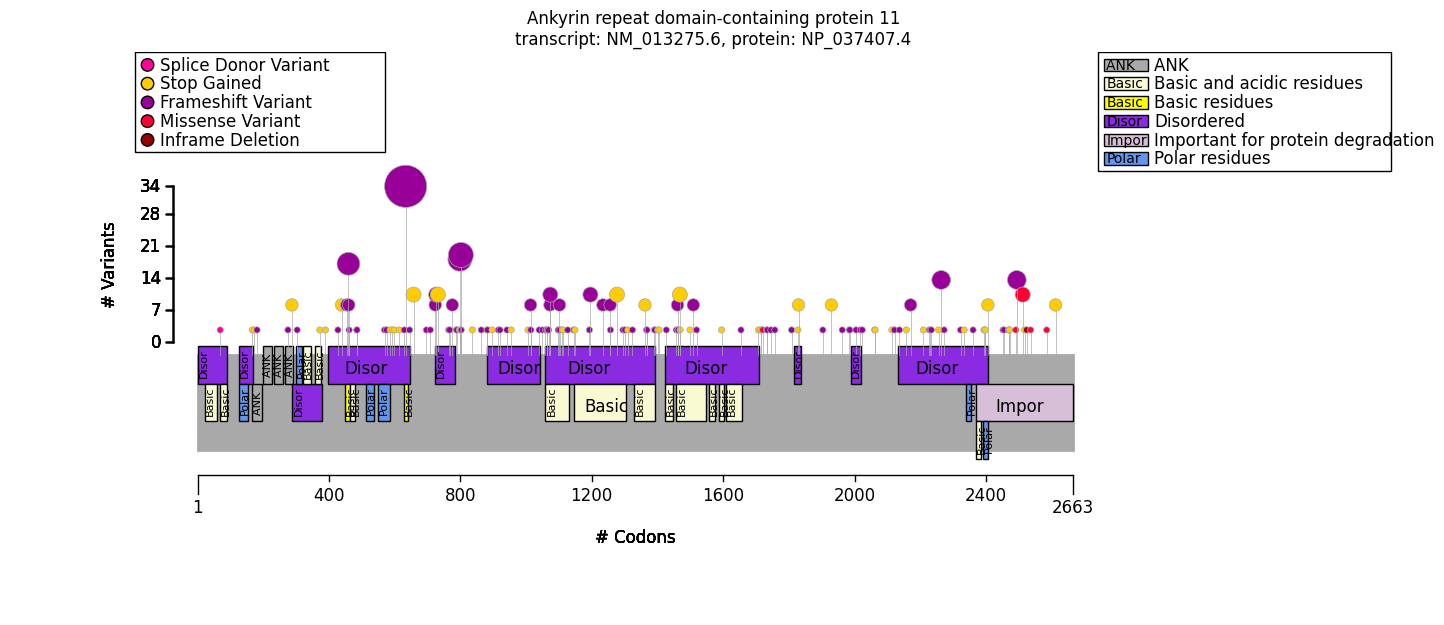

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


ankrd11_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
ankrd11_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)


Count,Name,Type,Coordinates,Variants
0,Disordered,Region,2 - 90,
0,Basic and acidic residues,Compositional bias,24 - 59,
0,Basic and acidic residues,Compositional bias,71 - 90,
1,Disordered,Region,129 - 169,p.Glu169Ter
0,Polar residues,Compositional bias,129 - 156,
3,ANK 1,Repeat,168 - 196,p.Arg174Ter; p.Glu169Ter; p.Arg183ProfsTer44
0,ANK 2,Repeat,201 - 229,
0,ANK 3,Repeat,234 - 262,
3,ANK 4,Repeat,267 - 292,p.Tyr289Ter; p.Thr278ArgfsTer3
2,Disordered,Region,290 - 380,p.Glu374Ter; p.Pro306HisfsTer62


# Strategy
Here, we will perform a version of the tests based on tests performed in [Martinez-Cayuelas E,et al., (2023) Clinical description, molecular delineation and genotype-phenotype correlation in 340 patients with KBG syndrome: addition of 67 new patients. J Med Genet](https://pubmed.ncbi.nlm.nih.gov/36446582/).

The authors identified a significantly higher frequency of patients with a triangular face in carriers of sequence variants compared to CNVs. Other associations found were short stature and variants in exon 9, a lower incidence of ID/ADHD/ASD in carriers of the c.1903_1907del variant and the size of the deletion, in CNV carriers, with the presence of macrodontia and hand anomalies.

We note that the authors did not apply multiple-testing correction. 

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect 
from gpsea.analysis.clf import monoallelic_classifier

cnv = variant_effect(VariantEffect.TRANSCRIPT_ABLATION, mane_tx_id)
cnv_predicate = monoallelic_classifier(a_predicate=cnv,
                                     b_predicate=~cnv,
                                     a_label="SV",
                                     b_label="other")
cnv_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=cnv_predicate,
    pheno_clfs=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(cnv_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,14
HMF03,Skipping term because of a child term with the same individual counts,8
HMF08,Skipping general term,53
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,111


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=cnv_result)

Allele group                                           SV            other  \
                                                    Count Percent    Count   
Short stature [HP:0004322]                          32/63     51%  118/196   
Long philtrum [HP:0000343]                          13/18     72%  108/134   
Intellectual disability [HP:0001249]                32/35     91%  162/188   
Global developmental delay [HP:0001263]             41/42     98%  135/142   
Delayed speech and language development [HP:000...  36/43     84%  124/144   
Macrodontia [HP:0001572]                            37/47     79%  174/218   
Neurodevelopmental abnormality [HP:0012759]         55/55    100%  208/208   
Feeding difficulties [HP:0011968]                   11/26     42%   59/136   
Growth delay [HP:0001510]                           34/34    100%  123/123   
Neurodevelopmental delay [HP:0012758]               43/43    100%  149/149   
Abnormal dental morphology [HP:0006482]             37/37    100%  174/174   
Abnormal oral cavity morphology [HP:0000163]        41/41    100%  208/208   
Thick eyebrow [HP:0000574]                          17/21     81%  109/134   
Abnormal eyebrow morphology [HP:0000534]            19/19    100%  119/119   
Language impairment [HP:0002463]                    36/36    100%  124/124   
Abnormal communication [HP:0034434]                 36/36    100%  124/124   
Abnormal speech pattern [HP:0002167]                36/36    100%  124/124   

Allele group                                                                   \
                                                   Percent Corrected p values   
Short stature [HP:0004322]                             60%                1.0   
Long philtrum [HP:0000343]                             81%                1.0   
Intellectual disability [HP:0001249]                   86%                1.0   
Global developmental delay [HP:0001263]                95%                1.0   
Delayed speech and language development [HP:000...     86%                1.0   
Macrodontia [HP:0001572]                               80%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Feeding difficulties [HP:0011968]                      43%                1.0   
Growth delay [HP:0001510]                             100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Abnormal dental morphology [HP:0006482]               100%                1.0   
Abnormal oral cavity morphology [HP:0000163]          100%                1.0   
Thick eyebrow [HP:0000574]                             81%                1.0   
Abnormal eyebrow morphology [HP:0000534]              100%                1.0   
Language impairment [HP:0002463]                      100%                1.0   
Abnormal communication [HP:0034434]                   100%                1.0   
Abnormal speech pattern [HP:0002167]                  100%                1.0   

Allele group                                                  
                                                    p values  
Short stature [HP:0004322]                          0.191182  
Long philtrum [HP:0000343]                          0.532058  
Intellectual disability [HP:0001249]                0.584670  
Global developmental delay [HP:0001263]             0.684570  
Delayed speech and language development [HP:000...  0.804778  
Macrodontia [HP:0001572]                            0.843600  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Feeding difficulties [HP:0011968]                   1.000000  
Growth delay [HP:0001510]                           1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Abnormal dental morphology [HP:0006482]             1.000000  
Abnormal oral cavity morphology [HP:0000163]        1.000000  
Thick eyebrow [HP:0000574]                          1.000000  
Abnormal eyebrow morphology [HP:

In [10]:
from gpsea.analysis.predicate import exon

ex9 = exon(exon=9, tx_id=mane_tx_id)
ex9_predicate = monoallelic_classifier(a_predicate=ex9,
                                     b_predicate=~ex9,
                                     a_label="exon 9",
                                     b_label="other")
ex9_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ex9_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=ex9_result)

Allele group                                         exon 9          other  \
                                                      Count Percent  Count   
Long philtrum [HP:0000343]                          113/140     81%   8/12   
Intellectual disability [HP:0001249]                171/199     86%  23/24   
Global developmental delay [HP:0001263]             164/171     96%  12/13   
Short stature [HP:0004322]                          138/235     59%  12/24   
Feeding difficulties [HP:0011968]                    63/149     42%   7/13   
Delayed speech and language development [HP:000...  151/176     86%   9/11   
Macrodontia [HP:0001572]                            191/241     79%  20/24   
Neurodevelopmental abnormality [HP:0012759]         237/237    100%  26/26   
Growth delay [HP:0001510]                           144/144    100%  13/13   
Neurodevelopmental delay [HP:0012758]               177/177    100%  15/15   
Abnormal dental morphology [HP:0006482]             191/191    100%  20/20   
Abnormal oral cavity morphology [HP:0000163]        227/227    100%  22/22   
Thick eyebrow [HP:0000574]                          113/139     81%  13/16   
Abnormal eyebrow morphology [HP:0000534]            125/125    100%  13/13   
Language impairment [HP:0002463]                    151/151    100%    9/9   
Abnormal communication [HP:0034434]                 151/151    100%    9/9   
Abnormal speech pattern [HP:0002167]                151/151    100%    9/9   

Allele group                                                                   \
                                                   Percent Corrected p values   
Long philtrum [HP:0000343]                             67%                1.0   
Intellectual disability [HP:0001249]                   96%                1.0   
Global developmental delay [HP:0001263]                92%                1.0   
Short stature [HP:0004322]                             50%                1.0   
Feeding difficulties [HP:0011968]                      54%                1.0   
Delayed speech and language development [HP:000...     82%                1.0   
Macrodontia [HP:0001572]                               83%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Growth delay [HP:0001510]                             100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Abnormal dental morphology [HP:0006482]               100%                1.0   
Abnormal oral cavity morphology [HP:0000163]          100%                1.0   
Thick eyebrow [HP:0000574]                             81%                1.0   
Abnormal eyebrow morphology [HP:0000534]              100%                1.0   
Language impairment [HP:0002463]                      100%                1.0   
Abnormal communication [HP:0034434]                   100%                1.0   
Abnormal speech pattern [HP:0002167]                  100%                1.0   

Allele group                                                  
                                                    p values  
Long philtrum [HP:0000343]                          0.266364  
Intellectual disability [HP:0001249]                0.329975  
Global developmental delay [HP:0001263]             0.450135  
Short stature [HP:0004322]                          0.515732  
Feeding difficulties [HP:0011968]                   0.561160  
Delayed speech and language development [HP:000...  0.661736  
Macrodontia [HP:0001572]                            0.793604  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Growth delay [HP:0001510]                           1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Abnormal dental morphology [HP:0006482]             1.000000  
Abnormal oral cavity morphology [HP:0000163]        1.000000  
Thick eyebrow [HP:0000574]                          1.000000  
Abnormal eyebrow morphology [HP:

In [11]:
from gpsea.analysis.predicate import variant_key

k635_var = variant_key("16_89284634_89284639_GTGTTT_G") #	c.1903_1907del	p.Lys635GlnfsTer26
k635_predicate = monoallelic_classifier(a_predicate=k635_var,
                                     b_predicate=~k635_var,
                                     a_label="c.1903_1907del",
                                     b_label="other")
k635_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=k635_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=k635_result)

Allele group                                       c.1903_1907del          \
                                                            Count Percent   
Intellectual disability [HP:0001249]                        14/19     74%   
Long philtrum [HP:0000343]                                  12/13     92%   
Global developmental delay [HP:0001263]                     15/16     94%   
Short stature [HP:0004322]                                  12/23     52%   
Delayed speech and language development [HP:000...          13/16     81%   
Thick eyebrow [HP:0000574]                                  10/13     77%   
Neurodevelopmental abnormality [HP:0012759]                 22/22    100%   
Feeding difficulties [HP:0011968]                            6/15     40%   
Growth delay [HP:0001510]                                   12/12    100%   
Neurodevelopmental delay [HP:0012758]                       16/16    100%   
Macrodontia [HP:0001572]                                    22/27     81%   
Abnormal dental morphology [HP:0006482]                     22/22    100%   
Abnormal oral cavity morphology [HP:0000163]                27/27    100%   
Abnormal eyebrow morphology [HP:0000534]                    13/13    100%   
Language impairment [HP:0002463]                            13/13    100%   
Abnormal communication [HP:0034434]                         13/13    100%   
Abnormal speech pattern [HP:0002167]                        13/13    100%   

Allele group                                          other          \
                                                      Count Percent   
Intellectual disability [HP:0001249]                180/204     88%   
Long philtrum [HP:0000343]                          109/139     78%   
Global developmental delay [HP:0001263]             161/168     96%   
Short stature [HP:0004322]                          138/236     58%   
Delayed speech and language development [HP:000...  147/171     86%   
Thick eyebrow [HP:0000574]                          116/142     82%   
Neurodevelopmental abnormality [HP:0012759]         241/241    100%   
Feeding difficulties [HP:0011968]                    64/147     44%   
Growth delay [HP:0001510]                           145/145    100%   
Neurodevelopmental delay [HP:0012758]               176/176    100%   
Macrodontia [HP:0001572]                            189/238     79%   
Abnormal dental morphology [HP:0006482]             189/189    100%   
Abnormal oral cavity morphology [HP:0000163]        222/222    100%   
Abnormal eyebrow morphology [HP:0000534]            125/125    100%   
Language impairment [HP:0002463]                    147/147    100%   
Abnormal communication [HP:0034434]                 147/147    100%   
Abnormal speech pattern [HP:0002167]                147/147    100%   

Allele group                                                           \
                                                   Corrected p values   
Intellectual disability [HP:0001249]                              1.0   
Long philtrum [HP:0000343]                                        1.0   
Global developmental delay [HP:0001263]                           1.0   
Short stature [HP:0004322]                                        1.0   
Delayed speech and language development [HP:000...                1.0   
Thick eyebrow [HP:0000574]                                        1.0   
Neurodevelopmental abnormality [HP:0012759]                       1.0   
Feeding difficulties [HP:0011968]                                 1.0   
Growth delay [HP:0001510]                                         1.0   
Neurodevelopmental delay [HP:0012758]                             1.0   
Macrodontia [HP:0001572]                                          1.0   
Abnormal dental morphology [HP:0006482]                           1.0   
Abnormal oral cavity morphology [HP:0000163]                      1.0   
Abnormal eyebrow morphology [HP:0000534]                          1.0   
Language impairmen

# ANKRD11 phenotypical score
[Martinez-Cayuelas et al. (2023)](https://pubmed.ncbi.nlm.nih.gov/36446582/) defined a phenotype score with 17 variables: ten from neurodevelopment and and phenotype categories, and seven main comorbidities. We did not attempt to exactly replicate the score, which involved some postprocessing of the raw data (e.g., up to one point was given from Characteristic nose, defined as anteverted nares, and/or bulbous tip, and/or prominent nose). If desired, one can implement rules such as this in a custom class (see the DeVries scorer in GPSEA). We reasoned that a similar simpler score would also yield a significant result if the signal was genuine.  The authors note that their phenotypical score was significantly higher in patients with sequence variants as compared with CNVs.

We implement our version of the ANKRD11 phenotypical score using the CountingPhenotypeScorer. This class assigns one point if one or more HPO annotations in an individual matches a target term. The score thus ranges from zero to the total number of target terms.

In [12]:
from gpsea.analysis.pscore import CountingPhenotypeScorer
gdd = hpotk.TermId.from_curie("HP:0001263") # Global developmental delay
md = hpotk.TermId.from_curie("HP:0001270") # Motor delay
sld = hpotk.TermId.from_curie("HP:0000750") # Delayed speech and language development
id = hpotk.TermId.from_curie("HP:0001249") # Intellectual disability
macrodontia = hpotk.TermId.from_curie("HP:0001572") # Macrodontia
anteverted_nares = hpotk.TermId.from_curie("HP:0000463") # Anteverted nares
bulbous_nose = hpotk.TermId.from_curie("HP:0000414") # Bulbous nose
hearing = hpotk.TermId.from_curie("HP:0000365") # Hearing impairment
otitis  = hpotk.TermId.from_curie("HP:0000403") # Recurrent otitis media
visual  = hpotk.TermId.from_curie("HP:0000505") # Visual impairment 
heart   = hpotk.TermId.from_curie("HP:0001627") # Abnormal heart morphology, approximation
seizure = hpotk.TermId.from_curie("HP:0001250") # Seizure  
feeding = hpotk.TermId.from_curie("HP:0011968") # Feeding difficulties
crypt = hpotk.TermId.from_curie("HP:0000028")   # Cryptorchidism 
adhd = hpotk.TermId.from_curie("HP:0007018") # Attention deficit hyperactivity disorder
aut_behavior = hpotk.TermId.from_curie("HP:0000729") # Autistic behavior
tooth = hpotk.TermId.from_curie("HP:0006482") # Abnormal dental morphology
triangular = hpotk.TermId.from_curie("HP:0000325") #Triangular face 
philtrum = hpotk.TermId.from_curie("HP:0000343") # Long philtrum 
low_set_ear = hpotk.TermId.from_curie("HP:0000369") # Low-set ears
hand = hpotk.TermId.from_curie("HP:0005922") # Abnormal hand morphology 
short = hpotk.TermId.from_curie("HP:0004322") #  Short stature 
ankrd11_score = [gdd, md, sld, id, macrodontia, anteverted_nares, bulbous_nose, hearing, otitis, visual, heart, seizure, feeding, crypt, adhd, aut_behavior, tooth, triangular, philtrum, hand, short]

count_scorer = CountingPhenotypeScorer(hpo=hpo, query=ankrd11_score)

In [17]:
from gpsea.analysis.pscore.stats import MannWhitneyStatistic
score_statistic = MannWhitneyStatistic()
from gpsea.analysis.pscore import PhenotypeScoreAnalysis
score_analysis = PhenotypeScoreAnalysis(
    score_statistic=score_statistic,
)

score_result = score_analysis.compare_genotype_vs_phenotype_score(
    cohort=cohort,
    gt_clf=cnv_predicate,
    pheno_scorer=count_scorer,
)
p_value_text = f"ANKRD11 phenotype score: p={score_result.pval:.4f}"
print(p_value_text)

ANKRD11 phenotype score: p=0.0003


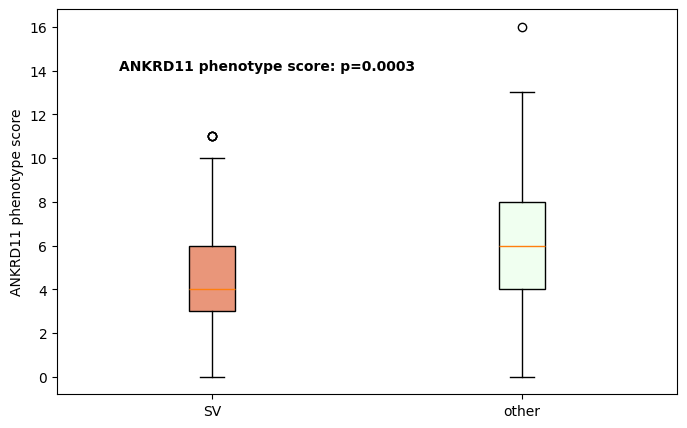

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))

ax.text(0.7, 14, p_value_text, weight='bold')
ax.set_ylabel("ANKRD11 phenotype score")

score_result.plot_boxplots(ax=ax)
plt.savefig("ANKRD11_phenoscore.pdf")

In [19]:
df = score_result.data
group0_mean = df[df["genotype"] == 0]["phenotype"].mean()
group1_mean = df[df["genotype"] == 1]["phenotype"].mean()
score_interpretation = f"AKKRD11 phenotype score for structural variants: {group0_mean:.2f}, and for other variants: {group1_mean:.2f}"
print(score_interpretation)

AKKRD11 phenotype score for structural variants: 4.62, and for other variants: 5.94


In [20]:
from gpsea.analysis.clf import sex_classifier
mf_result = score_analysis.compare_genotype_vs_phenotype_score(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_scorer=count_scorer,
)
p_value_text = f"M/F score: p={mf_result.pval:.4f}"
df = mf_result.data
# Note that female is represented as 0 and male as 1
group0_mean = df[df["genotype"] == 0]["phenotype"].mean()
group1_mean = df[df["genotype"] == 1]["phenotype"].mean()
score_interpretation = f"ANKRD11 phenotype score (male/female comparison): Female {group0_mean:.2f}, Male: {group1_mean:.2f}: p={mf_result.pval:.4f}"

print(score_interpretation)

ANKRD11 phenotype score (male/female comparison): Female 5.28, Male: 6.15: p=0.0075


# Summary

In [18]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


M_results = (
    GPAnalysisResultSummary.from_mono(
        result=score_result,
        xrefs={
            'ANKRD11 score': ('PMID: 36446582'),
        },
        interpretation=score_interpretation
    ),
    GPAnalysisResultSummary.from_mono(
        result=mf_result,
    )
)

F_results = (
    GPAnalysisResultSummary.from_multi(
         result=cnv_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=ex9_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=k635_result,
    )
)

ankrd11_caption = "Validated results on ANKRD11 phenotypical score. Other results did not survive multiple testing correction."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             mono_results=M_results,
                             fet_results=F_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=ankrd11_caption)

In [19]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [ ]:
summarizer.process_latex(report=report, protein_fig=ankrd11_fig)

Figure saved to ../../supplement/img/ANKRD11_protein_diagram-draft.pdf
Output to ../../supplement/tex/ANKRD11_summary_draft.tex
